# <center>Topic Modelling using Latent Dirichlet Allocation (LDA) on ICU Patient Transcripts</center>

<center>Tiffany Chu</center>


<center>COGS402</center>

---



## Photovoice Transcript

The dataset is just a massive 50 page document/ transcript. After converting the word docx into a json file, we have categories of participants, text, and time, and now using topic modelling with LDA, we can derive insights from this file

Since the textual data is qualitative, we can employ a qualitative method as a supplement of our actual analysis to back up our findings

Topic modeling can identify themes in a set of documents by using unsupervised learning to automatically groups words without a predefined list of labels. I chose an unsupervised method as current trained models like BERT and LLAMA care trained on massive amounts of human data, which may be biased, and the whole point of this is to mitigate that possibility

## What is LDA

Latent Dirichlet Allocation (LDA) is a statistical model/ algorithm within machine learning. This technique used in natural language processing (NLP) and text mining for topic modeling, which aims to discover abstract topics within a collection of documents.

- LDA is an supervised learning technique. It doesn't require labeled data; instead, it infers patterns and structures from the data itself.

- It involves estimating probability distributions, which is a fundamental aspect of many ML algorithms.

- LDA learns from the input corpus (text), identifying hidden topics by analyzing the co-occurrence patterns of words across documents.

- To form its model: starts by estimating parameters, such as topic-word distributions and document-topic distributions -- by iteratively updating and optimizing these distributions.

- Application in Decision Making: While LDA doesn't make explicit predictions, it enables understanding and organizing large sets of text data, which can inform decision-making processes



## Importing the Required Libraries

In [ ]:
import nltk
nltk.download("stopwords")
import string
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import numpy as np
import json
import glob
#import pandas as pd #need older vers, redownload

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [ ]:
!pip install pyLDAvis
#for vis
import pyLDAvis
import pyLDAvis.gensim_models



import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 37.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [1]:
# !pip install python-docx
# uncomment ^ if below function is needed

##WORD .DOCX TO .JSON CONVERSION FUNCTION

In [ ]:
from docx import Document
import json

def convert_docx_to_json(file_path):
    doc = Document(file_path)
    conversations = []

    current_speaker = None
    current_time = None
    current_speech = ''

    for paragraph in doc.paragraphs:
        text = paragraph.text.strip()

        if text.startswith("Facilitator") or text.startswith("P"):
            if current_speaker is not None:
                convo = {
                    "participant": current_speaker,
                    "time": current_time,
                    "speech": current_speech
                }
                conversations.append(convo)
                current_speech = ''

            parts = text.split(' ')
            current_speaker = parts[0]

            # gonna ignore indexerrors
            if len(parts) > 1:
                current_time = parts[1][1:-1]  # Extracting time without parentheses
            else:
                current_time = None
        else:
            current_speech += ' ' + text

    # add the last conversation to current
    if current_speaker is not None:
        convo = {
            "participant": current_speaker,
            "time": current_time,
            "speech": current_speech
        }
        conversations.append(convo)

    return conversations

# the path to your DOCX file
docx_file_path = 'sessions.docx'
conversations_json = convert_docx_to_json(docx_file_path)

# Output the JSON data
print(json.dumps(conversations_json, indent=2))

# File path where you want to save the JSON data
file_path = 'sessions.json'

# Open the file in write mode and save the JSON data
with open(file_path, 'w') as file:
    json.dump(conversations_json, file, indent=4)


# REMEMBER TO DOWNLOAD THE JSON FILE!!!


## Preparing the Data
###    text pre-processing

In [ ]:
#function to put file into read and write mode
# made functions to read JSON data from a file (load_data) and write JSON data
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f)
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)


In [ ]:
from nltk.corpus import stopwords
#exclude these words
stopwords = stopwords.words("english")
stopwords = [word for word in stopwords if len(word) >= 5]
stopwords.extend(['','from', 'go', 'so', 'know', 'subject', 're', 'edu', 'use', 'participant', 'P1', 'P2', 'P3', 'P4', 'P5', 'Facilitator','um','uh', 'for', 'same','hubby'])

In [ ]:
print (stopwords)

['myself', 'ourselves', "you're", "you've", "you'll", "you'd", 'yours', 'yourself', 'yourselves', 'himself', "she's", 'herself', 'itself', 'their', 'theirs', 'themselves', 'which', "that'll", 'these', 'those', 'being', 'having', 'doing', 'because', 'until', 'while', 'about', 'against', 'between', 'through', 'during', 'before', 'after', 'above', 'below', 'under', 'again', 'further', 'there', 'where', 'other', "don't", 'should', "should've", "aren't", 'couldn', "couldn't", "didn't", 'doesn', "doesn't", "hadn't", "hasn't", 'haven', "haven't", "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", "shan't", 'shouldn', "shouldn't", "wasn't", 'weren', "weren't", "won't", 'wouldn', "wouldn't", '', 'from', 'go', 'so', 'know', 'subject', 're', 'edu', 'use', 'participant', 'P1', 'P2', 'P3', 'P4', 'P5', 'Facilitator', 'um', 'uh', 'for', 'same', 'hubby']


In [ ]:
#IMPORTANT!!! PUT THE JSON FILE IN CONTENT FOLDER IN UPLOADS!!!!
# just a test to output a sample of the intial text

data = load_data("sessions.json")

# Access the third element (multiple dictionaries in the list)
first_element = data[3]

# Access the "speech" key from the first element
speech_text = first_element["speech"]

# Print the first 90 characters of the speech
print(speech_text[:200])

 I was leaving the safety of the hospital and then to kind of an unknown. The picture, represents the unknown on the other side, and it's almost a bit of a hill. And, and at the same time, that log is


In [ ]:
import os

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

#IF UPLOADED ELSEWHERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! SHOULD OUTPUT /content

Current Working Directory: /content


In [ ]:

# Function for removing stopwords
def remove_stopwords(texts, stopwords):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

# Function for lemmatization
def lemmatization(texts, stopwords, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)

    # Remove stopwords after lemmatization
    texts_out = remove_stopwords(texts_out, stopwords)

    return texts_out

# Read data from the file
with open('sessions.json', 'r') as file:
    data = json.load(file)

# Extract speech texts from the data
speech_texts = [item.get('speech', '') for item in data]


# Perform lemmatization and stopword removal
lemmatized_texts = lemmatization(speech_texts, stopwords)

texts = lemmatized_texts


# Convert list of lists to list of strings
processed_texts_strings = [' '.join(text) if text else '' for text in texts]

text = processed_texts_strings

# Print the processed texts
print(text)

['', '', 'idea mind photo want take road actually just road cause feel journey road journey long road then come take park come outta park right see just almost slam brake unfortunately get side road just speak just get very emotional whole time think want photo et cetera et cetera just speak fact have cross point', 'leave safety hospital then kind of unknown picture represent unknown side almost bit hill time log cover moss transfer log dangerous scary feel leave safety net hospital give fact night event almost pass bathroom still send home next morning very apprehensive transition home fear landing post long haul symptom live fear get case get sick end back hospital experience all over kinda represent just speak just take photo pleasure give lot time think want question', 'feel wanna wanna', '', 'thank lovely photograph thank explain process incredible just drive along see think speak little bit last week pop', 'picture road actually stand make sure traffic get middle road great happy

In [ ]:
# Adjusted gen_words function to handle a list of lists
def gen_words(texts):
    final = []
    for sublist in texts:
        for text in sublist:
            new = gensim.utils.simple_preprocess(text, deacc=True)
            final.append(new)
    return final

data_words = gen_words(texts)

print(data_words[3])

['want']


In [ ]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

print(corpus[2][0:20])

#Bag of Words representation of the first text (index 2) and displays the first 20 elements (ID, frequency)

[(2, 1)]


In [ ]:
word = id2word[0]
print(word)
# first word sneak peek

idea


##Building the LDA topic model

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,              # The corpus(collection) of texts to train the model
    id2word=id2word,            # Mapping from word IDs to words
    num_topics=20,              # The number of topics to be generated
    random_state=100,           # Seed for random number generation (for reproducibility)
    update_every=1,              # How often the model parameters should be updated
    chunksize=100,               # Number of documents to be used in each training chunk
    passes=10,                   # Number of passes through the corpus during training
    alpha="auto"                 # Alpha parameter for LDA (auto sets it automatically)
)

# I think these parameters make the most sense. bc intuition

## Vizualizing the Data

In [ ]:
!pip install "pandas<2.0.0"
#visualize terms and their frequency BUT GOTTA DOWNLOAD THE OLDER PANDAS LIBRARY

#IGNORE THE WARNING TO RESTART RUNTIME to save time !!!!

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.376622  0.355559       1        1  22.270674
19     0.210126 -0.474079       2        1  12.038188
10    -0.346203 -0.213461       3        1   6.313448
15    -0.198125  0.344860       4        1   6.165483
7      0.222883 -0.201363       5        1   6.160727
3      0.312900 -0.053857       6        1   5.923962
1      0.034040  0.382398       7        1   5.878971
2     -0.145359 -0.333656       8        1   4.459316
5     -0.268441  0.145662       9        1   4.385295
0      0.223476  0.158832      10        1   3.699808
18     0.137353  0.046396      11        1   3.158542
12    -0.020910  0.038705      12        1   3.059689
13    -0.304205 -0.010306      13        1   2.804043
8     -0.063501  0.085218      14        1   2.255062
16    -0.047635 -0.169048      15        1   2.173585
6     -0.065293  0.029205      16        1   1.979336
17    -0.035589 -0.019701      17        1   1.966037
9     -0.099829 -0.016553      18        1   1.887647
4      0.071852 -0.111898      19        1   1.813668
14     0.005840  0.017088      20        1   1.606519, topic_info=         Term         Freq        Total Category  logprob  loglift
7        just  3373.000000  3373.000000  Default  30.0000  30.0000
29      think  1995.000000  1995.000000  Default  29.0000  29.0000
9        feel   925.000000   925.000000  Default  28.0000  28.0000
22        get   760.000000   760.000000  Default  27.0000  27.0000
40         of   801.000000   801.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
24      speak     0.162038   250.898731  Topic20  -7.7195  -3.2139
25       very     0.162038   514.181899  Topic20  -7.7195  -3.9314
26  emotional     0.162038     3.615103  Topic20  -7.7195   1.0261
27      whole     0.162038    76.661167  Topic20  -7.7195  -2.0282
28       time     0.162038   494.956189  Topic20  -7.7195  -3.8933

[1170 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6         4  0.987235    actually
18       17  0.940148      almost
44        4  0.987630         bit
8         2  0.910610       cause
13        1  0.994796        come
32       17  0.890144        fact
9         6  0.996460        feel
22        8  0.995801         get
53       11  0.982219        give
33        1  0.976389        have
60       12  0.976473        home
38       11  0.977730    hospital
0        13  0.974440        idea
10        9  0.972621     journey
7         1  0.998991        just
39        4  0.994670        kind
11       14  0.974225        long
61       19  0.984161        next
40        5  0.995660          of
56       18  0.912982        pass
2         2  0.993983       photo
42       10  0.994094     picture
35       16  0.961461       point
67       20  0.955250        post
43        5  0.924980   represent
16        7  0.989319       right
5        16  0.780711        road
17        7  0.994717         see
59       14  0.750809        send
24       15  0.984461       speak
58        5  0.975306       still
4         3  0.995312        take
12        1  0.992899        then
29        2  0.998350       think
28        3  0.994027        time
64       10  0.206245  transition
25        9  0.993812        very
3        13  0.987720        want
27       18  0.952242       whole, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 20, 11, 16, 8, 4, 2, 3, 6, 1, 19, 13, 14, 9, 17, 7, 18, 10, 5, 15])

produced topics and the associated keywords. Each bubble on the left-hand side plot represents a topic. A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

Red bars give the estimated number of times a given term was generated by a given topic. As you can see, there are about 20 uses of the word surgery, and this term is used about 15 times within topic 9.

#Interpreting the Visualization:

**Topic Circles:** Each circle represents a topic. The larger the circle, the more prevalent the topic is in the corpus.

###Intertopic Distance Map (distance from center):

 Closer Topics - When topics are closer to each other on the intertopic distance map, it indicates that these topics share more similarities or have more common words and themes. These topics might be more closely related in terms of content or subject matter.

###Topic Details:

**Topic Sizes:** The size of each topic circle corresponds to the prevalence or weight of that topic in the entire corpus.
**Top Words:** Hovering over a topic circle displays the top words associated with that topic. These words are the most relevant terms defining that topic.

###Visualization Controls:

**Relevance Sliders:** Adjusting the relevance sliders (lambda values) can change the displayed words' relevance to the selected topic versus their overall frequency in the corpus. It helps in fine-tuning the word display based on relevance to the topic.


MORE

In [ ]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[2][0:10])

['photo']


In [ ]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe.  can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [ ]:
 id2word = corpora.Dictionary(texts)

 corpus = []
 for text in data_words:
     new = id2word.doc2bow(text)
     corpus.append(new)

 print (corpus[3][0:20])

 word = id2word[[0][:1][0]]
 print (word)

[(3, 1)]
idea


In [ ]:
#test
test_doc = corpus[-1]

vector = lda_model[test_doc]
print (vector)

def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    sub_li.reverse()
    return (sub_li)
new_vector = Sort(vector)
print (new_vector)

[(0, 0.036703672), (1, 0.058065116), (2, 0.04413403), (3, 0.05843656), (4, 0.019063387), (5, 0.0433787), (6, 0.020621985), (7, 0.060823098), (8, 0.023019478), (9, 0.019650357), (10, 0.062364485), (11, 0.22244063), (12, 0.030550284), (13, 0.028185891), (14, 0.017172165), (15, 0.060896657), (16, 0.022349618), (17, 0.02041201), (18, 0.031559136), (19, 0.12017278)]
[(11, 0.22244063), (19, 0.12017278), (10, 0.062364485), (15, 0.060896657), (7, 0.060823098), (3, 0.05843656), (1, 0.058065116), (2, 0.04413403), (5, 0.0433787), (0, 0.036703672), (18, 0.031559136), (12, 0.030550284), (13, 0.028185891), (8, 0.023019478), (16, 0.022349618), (6, 0.020621985), (17, 0.02041201), (9, 0.019650357), (4, 0.019063387), (14, 0.017172165)]


In [ ]:
#basically a topic and its list of word:weight (for example the second is about health and eating well) multiplied (*) the weight of its significance
lda_model.print_topics()

[(0,
  '0.666*"picture" + 0.002*"transition" + 0.000*"field" + 0.000*"restaurant" + 0.000*"link" + 0.000*"gut" + 0.000*"afterwards" + 0.000*"lunch" + 0.000*"expertise" + 0.000*"downstairs"'),
 (1,
  '0.544*"see" + 0.249*"right" + 0.000*"thank" + 0.000*"really" + 0.000*"guy" + 0.000*"thing" + 0.000*"laugh" + 0.000*"say" + 0.000*"love" + 0.000*"learn"'),
 (2,
  '0.747*"get" + 0.000*"vegetable" + 0.000*"afterwards" + 0.000*"field" + 0.000*"expertise" + 0.000*"restaurant" + 0.000*"link" + 0.000*"can" + 0.000*"grow" + 0.000*"intertwine"'),
 (3,
  '0.685*"feel" + 0.000*"thank" + 0.000*"really" + 0.000*"thing" + 0.000*"say" + 0.000*"guy" + 0.000*"laugh" + 0.000*"good" + 0.000*"much" + 0.000*"talk"'),
 (4,
  '0.492*"next" + 0.000*"restaurant" + 0.000*"downstairs" + 0.000*"afterwards" + 0.000*"field" + 0.000*"expertise" + 0.000*"link" + 0.000*"vegetable" + 0.000*"can" + 0.000*"lunch"'),
 (5,
  '0.513*"very" + 0.130*"journey" + 0.000*"restaurant" + 0.000*"downstairs" + 0.000*"afterwards" + 0.000

In [ ]:
# Model perplexity and topic coherence provide a reliable
# measure to judge how good a given topic model is.

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -25.070848996627348

Coherence Score:  0.7661417007324783


## interpreting the topic model

- Perplexity:  -26.503638525437097
- Coherence Score:  0.7668721346903007

The perplexity and coherence score are two metrics used to evaluate topic models

Perplexity: A measure of how well the model predicts a sample. Lower perplexity values indicate better performance. A perplexity of -6.496 indicates that the model, on average, is making relatively good predictions about unseen data. (also, it is calculated over the log of probabilities so it is negative)

Coherence Score: Measures the interpretability of the topics. It quantifies how semantically similar the high-scoring words within a topic are. A coherence score of 0.455 indicates a moderate level of interpretability in the topics generated by the model. Higher coherence scores generally imply more interpretable and coherent topics.

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics = []

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics.append([int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]])
            else:
                break

    return sent_topics


#Adjust the lemmatization function to accept the output of gen_words
def lemmatization_from_words(words, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for words_list in words:
        text = " ".join(words_list)
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return texts_out


# Use gen_words to process lemmatization and then pass it to format_topics_sentences
data_words = gen_words(speech_texts)
lemmatized_texts = lemmatization_from_words(data_words)
topics_info = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=lemmatized_texts)

#  topics_info contains the information of each document's dominant topic, percentage contribution, keywords, and original text

topics_info = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=lemmatized_texts)

#mimicking the display of df_dominant_topic.head(10)
print("Document_No, Dominant_Topic, Topic_Perc_Contrib, Keywords, Text")
for i, row in enumerate(topics_info[:10]):  # Printing the first 10 rows
    document_no = i
    dominant_topic, perc_contrib, keywords, text = row
    print(f"{document_no}, {dominant_topic}, {perc_contrib}, {keywords}, {text}")

Document_No, Dominant_Topic, Topic_Perc_Contrib, Keywords, Text
0, 13, 0.4472000002861023, want, idea, expertise, downstairs, gut, afterwards, field, eating, restaurant, can, 
1, 11, 0.2223999947309494, just, come, then, have, thank, really, say, guy, laugh, thing, 
2, 19, 0.49950000643730164, think, photo, cause, thank, really, say, guy, laugh, thing, good, 
3, 13, 0.4472000002861023, want, idea, expertise, downstairs, gut, afterwards, field, eating, restaurant, can, 
4, 10, 0.4666999876499176, take, time, thank, really, guy, say, laugh, thing, much, good, 
5, 6, 0.44290000200271606, point, road, restaurant, gut, afterwards, field, expertise, eating, lunch, downstairs, 
6, 15, 0.4657999873161316, kind, bit, actually, thank, really, thing, laugh, guy, say, much, 
7, 11, 0.557699978351593, just, come, then, have, thank, really, say, guy, laugh, thing, 
8, 6, 0.44290000200271606, point, road, restaurant, gut, afterwards, field, expertise, eating, lunch, downstairs, 
9, 19, 0.499500006437

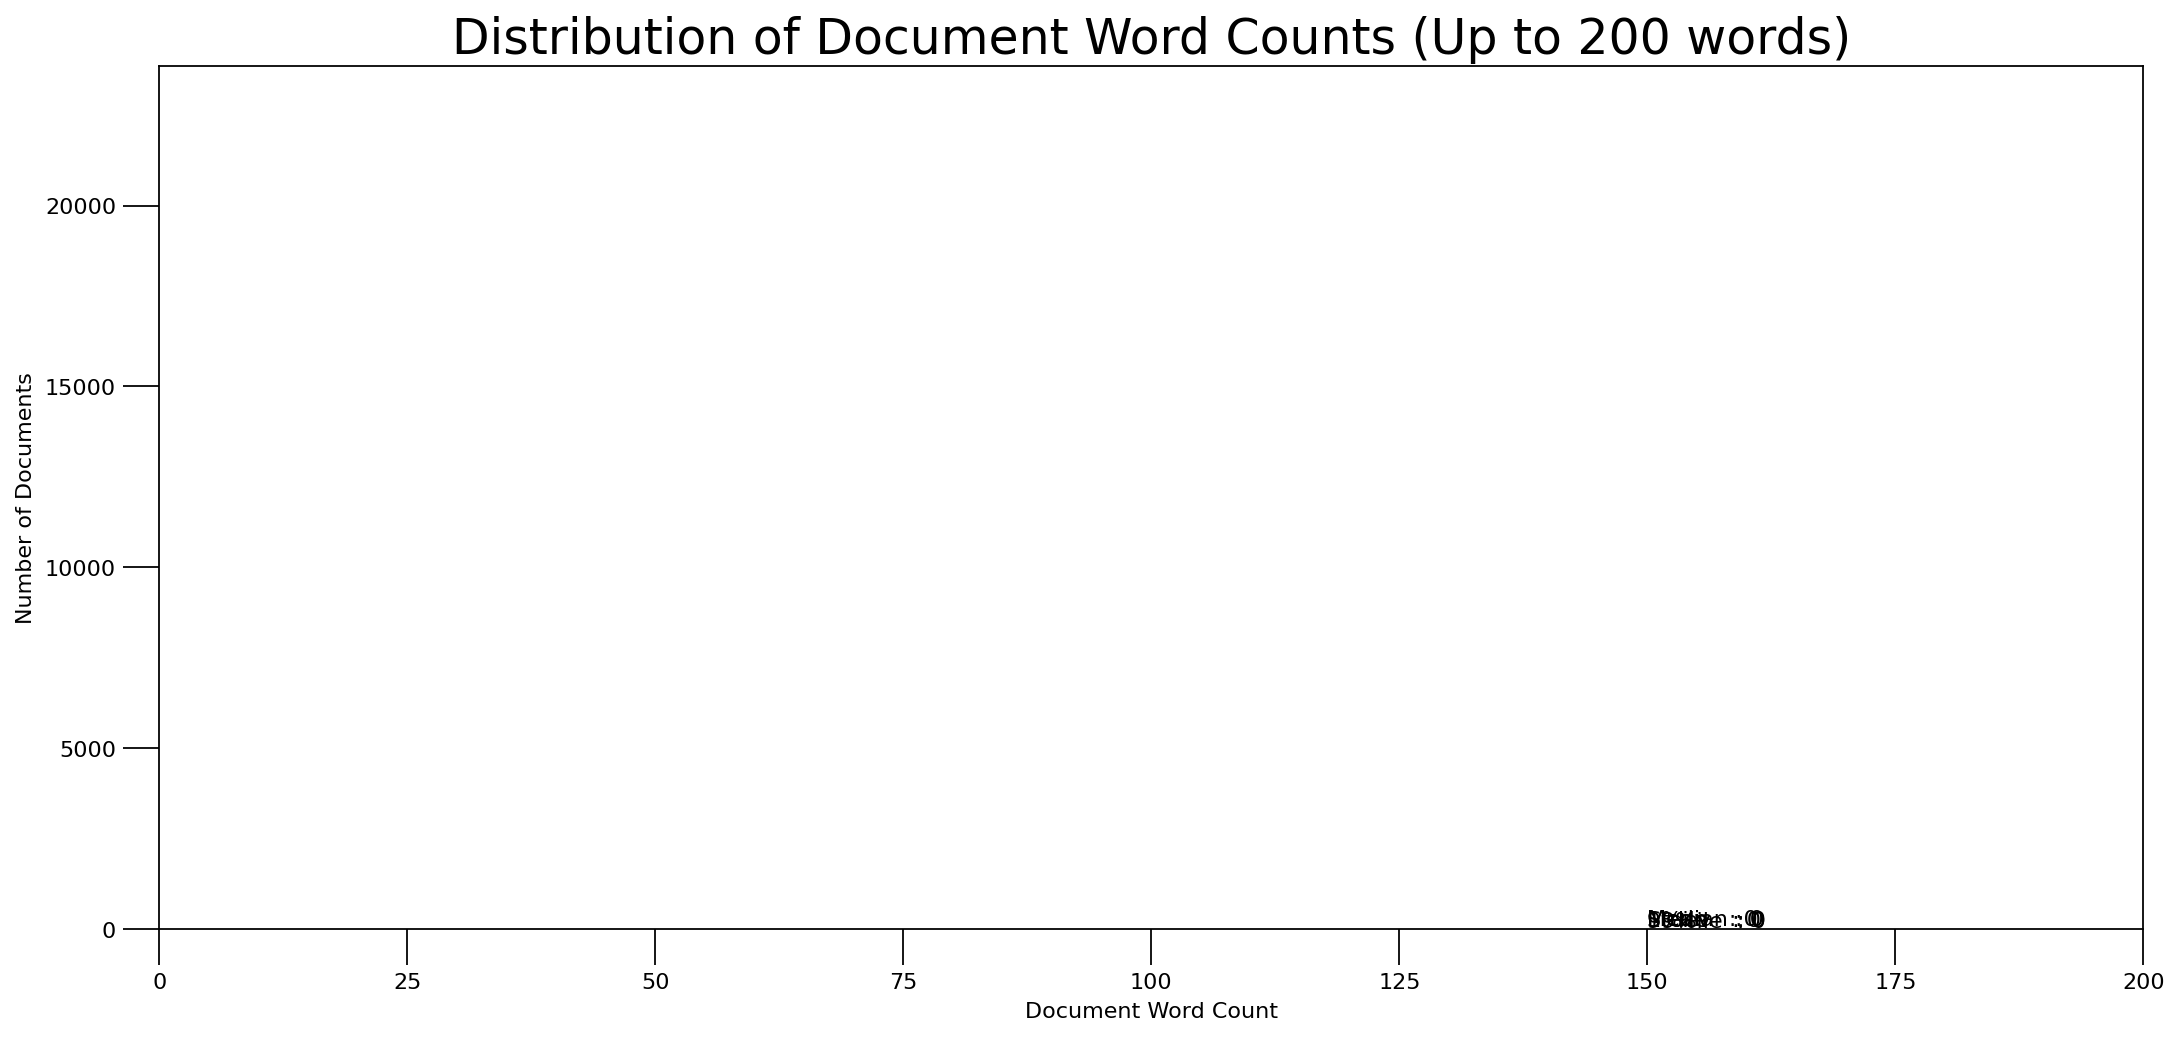

In [ ]:
# Calculate document lengths from topics_info
doc_lens = [len(row[3].split()) for row in topics_info]  # Assuming the text is at index 3 of each row

# Plot
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 7), dpi=160)
plt.hist(doc_lens, bins=200, color='navy')  # Reduce the number of bins for better visibility
plt.text(150, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(150, 90, "Median : " + str(round(np.median(doc_lens))))
plt.text(150, 80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(150, 70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(150, 60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 200), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0, 200, 9))
plt.title('Distribution of Document Word Counts (Up to 200 words)', fontdict=dict(size=22))
plt.show()

#how big the documents are as a whole and by topic. plots the document word counts distribution.

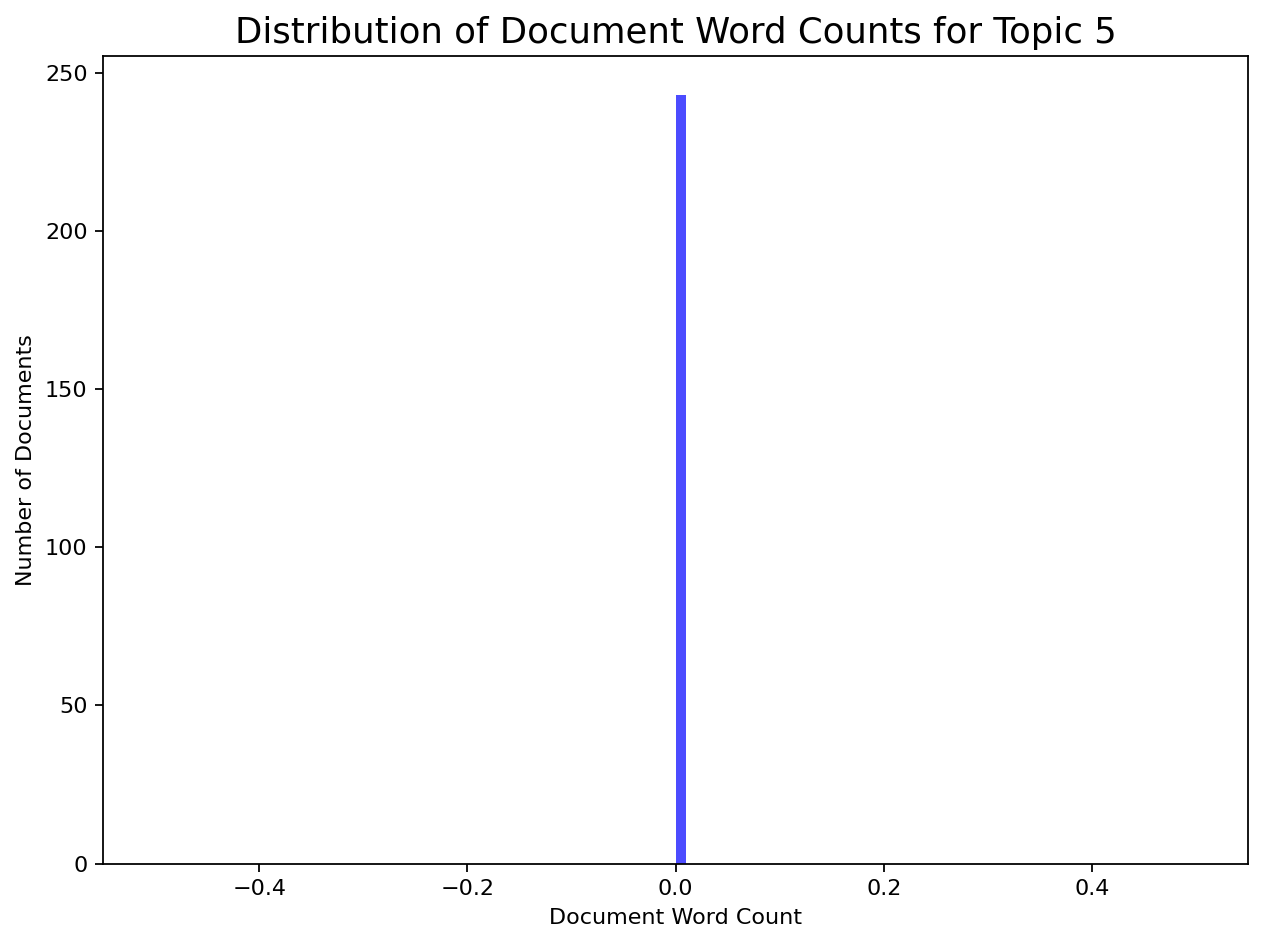

In [ ]:
topic_id = 5  # Choose the specific topic (Topic 5 in this case)
doc_lens_topic_5 = [len(d[3].split()) for d in topics_info if d[0] == topic_id]  # Counting words in the 'Text' field for Topic 5

import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6), dpi=160)

ax.hist(doc_lens_topic_5, bins=100, color='blue', alpha=0.7)
ax.set_xlabel('Document Word Count')
ax.set_ylabel('Number of Documents')
ax.set_title(f'Distribution of Document Word Counts for Topic {topic_id}', fontdict={'size': 16})

plt.tight_layout()
plt.show()

#shows how many documents



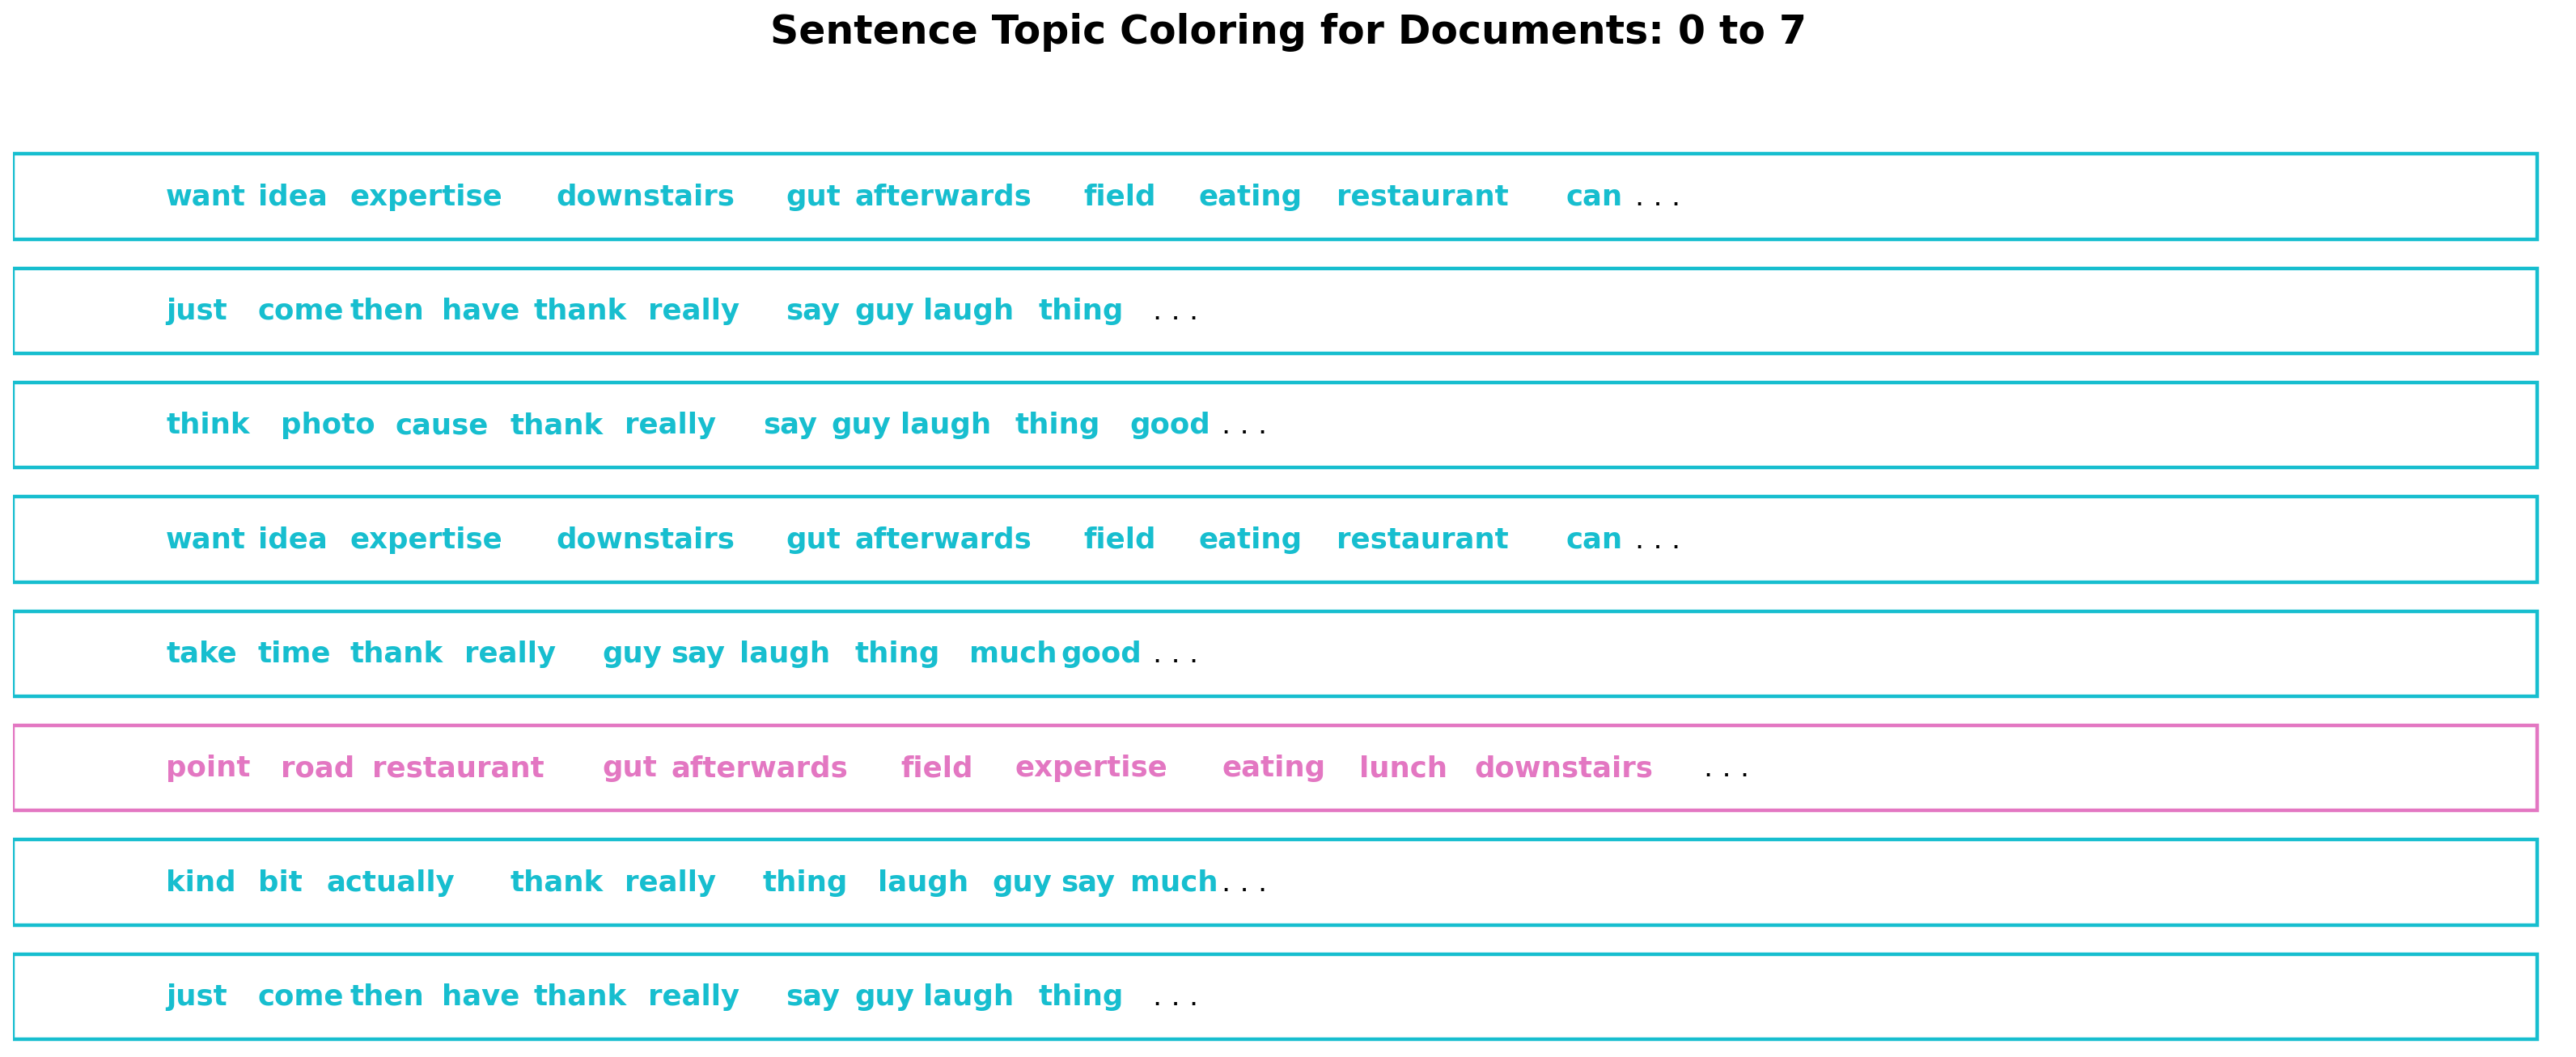

In [ ]:

from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end - start, 1, figsize=(20, (end - start) * 0.95), dpi=160)
    axes[0].axis('off')

    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i - 1]
            topics = lda_model.get_document_topics(corp_cur, minimum_probability=0.0)

            if topics:
                dominant_topic = max(topics, key=lambda x: x[1])[0]
                topic_words = lda_model.show_topic(dominant_topic)
                topic_keywords = ", ".join([word for word, prop in topic_words])

                # Ensure dominant_topic is within the range of available colors
                dominant_topic = min(dominant_topic, len(mycolors) - 1)

                ax.text(0.01, 0.5, f"Doc {i - 1} - Topic {dominant_topic}: {topic_keywords}",
                        verticalalignment='center', fontsize=16, color='white',
                        transform=ax.transAxes, fontweight=700)

                ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                       color=mycolors[dominant_topic], linewidth=2))

                word_pos = 0.06
                for word, _ in topic_words[:14]:
                    ax.text(word_pos, 0.5, word, horizontalalignment='left',
                            verticalalignment='center', fontsize=16, color=mycolors[dominant_topic],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += 0.009 * len(word)
                    ax.axis('off')

                ax.text(word_pos, 0.5, '. . .', horizontalalignment='left',
                        verticalalignment='center', fontsize=16, color='black',
                        transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end - 2), fontsize=22, y=0.95,
                 fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart(start=0, end=9)

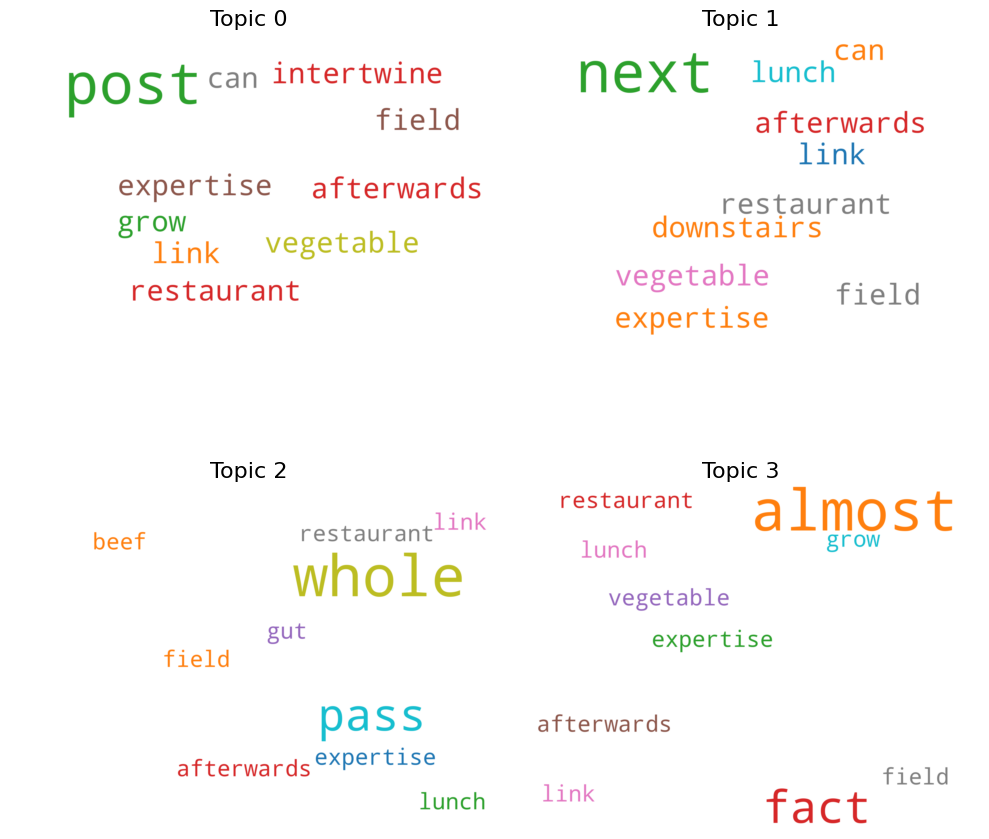

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def generate_wordclouds(lda_model, topics):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    cloud = WordCloud(
        background_color='white',
        width=2500,
        height=1800,
        max_words=10,
        colormap='tab10',
        prefer_horizontal=1.0
    )

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        ax.imshow(cloud, interpolation='bilinear')
        ax.set_title('Topic ' + str(i), fontdict=dict(size=16))
        ax.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

# Assuming `lda_model` and `topics_info` are available from the previous code

# Extracting topics from the LDA model
topics = lda_model.show_topics(formatted=False)

# Generating word clouds for the topics
generate_wordclouds(lda_model, topics)


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category10_10

# Generate sample data (replace this with your data)
X, _ = make_blobs(n_samples=100, centers=4, n_features=5, random_state=42)

# Perform t-SNE
tsne_model = TSNE(n_components=2, random_state=42)
tsne_lda = tsne_model.fit_transform(X)

# Infer topic numbers (replace this with your algorithm)
# For example, k-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
topic_num = kmeans.fit_predict(X)

# Creating a Bokeh plot for t-SNE clustering of LDA Topics
n_topics = 4  # Replace with your specific number of topics
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

# Set up a Bokeh plot
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), width=800, height=600)

# Check if 'tsne_lda' and 'topic_num' lengths match or adjust them accordingly
min_len = min(len(tsne_lda), len(topic_num))
tsne_lda = tsne_lda[:min_len]
topic_num = topic_num[:min_len]

# Create a ColumnDataSource for data
if tsne_lda.shape[1] == 1:
    source = ColumnDataSource(data=dict(x=tsne_lda[:, 0], y=tsne_lda[:, 0], color=mycolors[topic_num]))
else:
    source = ColumnDataSource(data=dict(x=tsne_lda[:, 0], y=tsne_lda[:, 1], color=mycolors[topic_num]))

# Scatter plot of t-SNE clusters
plot.scatter('x', 'y', source=source, fill_alpha=0.6, line_alpha=0.6)

# Show the plot
show(plot)


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x788c9033f250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so: cannot open shared object file: No such file or directory
/usr/local/lib/python3.10/dist-packages/skle